In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import math
import pickle

In [2]:
def get_coord_grid(H, W):
    """
    Returns a tensor of shape (H*W, 2) with normalized (x, y) coordinates
    in the range [-1, 1].
    """
    y = torch.linspace(-1, 1, steps=H)
    x = torch.linspace(-1, 1, steps=W)
    yy, xx = torch.meshgrid(y, x, indexing="ij")
    coords = torch.stack([xx, yy], dim=-1)  # (H, W, 2)
    coords = coords.reshape(-1, 2)          # (H*W, 2)
    return coords

# MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),  # (H,W) in [0,1]
])
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

# Define target image
H, W = 28, 28
coords = get_coord_grid(H, W)

In [8]:
# --------------------------
# RuleNet
# --------------------------
class RuleNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.hidden_dim = hidden_dim

    def forward(self, x, weights):
        """
        coords: (B, N, 2)
        weights: list of [W1, b1, W2, b2, W3, b3]
        """
        W1, b1, W2, b2, W3, b3 = weights

        h1 = torch.bmm(x, W1.transpose(1,2)) + b1
        h1 = torch.sin(h1)

        # Layer 2: (B, N, 16)
        h2 = torch.bmm(h1, W2.transpose(1,2)) + b2
        h2 = torch.sin(h2)

        # Layer 3: (B, N, 1)
        out = torch.bmm(h2, W3.transpose(1,2)) + b3
        out = torch.sigmoid(out)
        return out  # (B, N, 1)


# --------------------------
# HyperNet (Generator)
# --------------------------
class HyperNetGen(nn.Module):
    def __init__(self, hidden_dim=256, latent_dim=64, rule_dims=[(8,16),(16,16),(16,1)]):
        super().__init__()
        self.latent_dim = latent_dim
        self.rule_dims = rule_dims

        # Decoder (maps z → all RuleNet weights flattened)
        total_weights = sum(in_d*out_d + out_d for in_d, out_d in rule_dims)
        self.dec_fc1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_fc2 = nn.Linear(hidden_dim, total_weights)

    def decode(self, z):
        h = torch.relu(self.dec_fc1(z))
        flat_weights = self.dec_fc2(h)

        # Split into RuleNet weight matrices/biases
        weights = []
        idx = 0
        for in_d, out_d in self.rule_dims:
            W_size = in_d * out_d
            b_size = out_d

            W = flat_weights[:, idx:idx+W_size].view(-1, out_d, in_d)
            idx += W_size
            b = flat_weights[:, idx:idx+b_size].view(-1, 1, out_d)
            idx += b_size

            weights.extend([W.squeeze(0), b.squeeze(0)])

        return weights

    def forward(self, z):
        """
        imgs: (batch, 1, 28, 28)
        """
        weights = self.decode(z)
        return weights

# --------------------------
# Discriminator
# --------------------------
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super().__init__()
        self.C1 = nn.utils.spectral_norm(nn.Conv2d(img_channels, 16, 4, 2, 1))
        self.C2 = nn.utils.spectral_norm(nn.Conv2d(16, 32, 4, 2, 1))
        self.C3 = nn.utils.spectral_norm(nn.Conv2d(32 + 1, 32, 3, 1, 1))
        self.D1 = nn.Linear(32*7*7, 1)

    def forward(self, x):
        x = F.leaky_relu(self.C1(x))
        x = F.leaky_relu(self.C2(x))

        std = torch.std(x, dim=0, keepdim=True)  # across batch
        mean_std = std.mean().expand(x.size(0), 1, x.size(2), x.size(3))
        x = torch.cat([x, mean_std], dim=1)

        x = F.leaky_relu(self.C3(x)).view(x.shape[0], 32*7*7)
        x = self.D1(x)
        return x

Epoch: 0/5 Iteration 0 Loss:0.0353


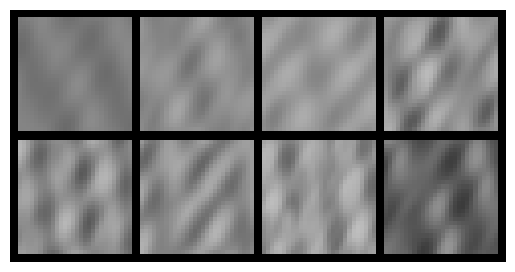

Epoch: 0/5 Iteration 1000 Loss:0.9471


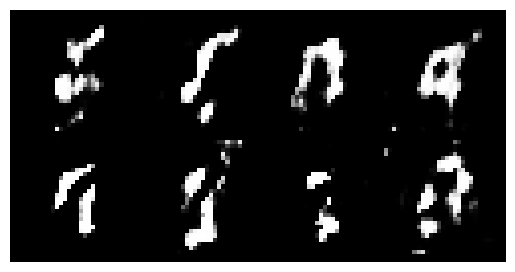

Epoch: 0/5 Iteration 2000 Loss:2.1234


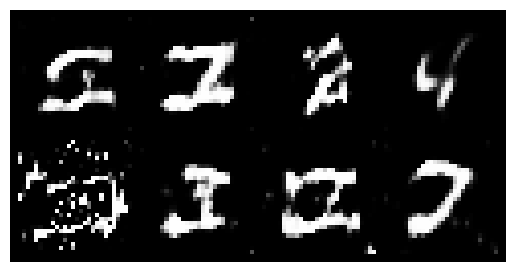

Epoch: 0/5 Iteration 3000 Loss:1.229


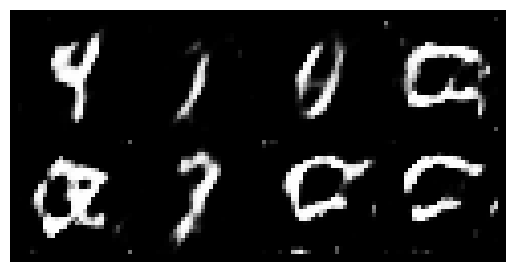

In [ ]:
hypernetG = HyperNetGen()
netD = Discriminator()
rulenet = RuleNet()

optG = torch.optim.Adam(hypernetG.parameters(), lr=1e-3)
optD = torch.optim.Adam(netD.parameters(), lr=2e-3)
epochs = 5

B = torch.randn(4, 2)
x_proj = 2 * torch.pi * coords @ B.T
x_proj = torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

for epoch in range(epochs):
    for k, (imgs, _) in enumerate(train_loader):
        #coords_ = coords.view(1, -1, 2).repeat(imgs.shape[0], 1, 1)
        x_proj_ = x_proj.view(1, 784, 8).repeat(imgs.shape[0], 1, 1)
        x_proj_ += 0.01*torch.randn_like(x_proj_)

        # HyperNet → weights
        z = torch.randn(imgs.shape[0], 64)
        weights = hypernetG(z)
        # RuleNet forward
        out_flat = rulenet(x_proj_, weights)  # (batch, N, 1)
        out_img = out_flat.view(-1, 1, 28, 28)


        # ----------------------
        # Adversarial training
        # ----------------------
        # Discriminator step
        d_real = netD(imgs)
        d_fake = netD(out_img.detach())
        d_loss = torch.mean(F.relu(1.0 - d_real)) + torch.mean(F.relu(1.0 + d_fake))

        optD.zero_grad()
        d_loss.backward()
        optD.step()

        # Generator (encoder) step: fool discriminator
        d_fake = netD(out_img)
        g_loss = -torch.mean(d_fake)

        optG.zero_grad()
        g_loss.backward()
        optG.step()

        if k % 1000 == 0:
          print(f"Epoch: {epoch}/{epochs} Iteration {k} Loss:{round(g_loss.item(), 4)}")

          grid = make_grid(out_img, nrow=4)
          grid = grid.numpy().transpose(1, 2, 0)
          plt.imshow(grid)
          plt.axis('off')
          plt.show()

